# Prototype/Model Based Clustering

## K-means

In [1]:
from sklearn import datasets
from sklearn.metrics import adjusted_mutual_info_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns

%matplotlib inline

We will play again with the iris dataset, now using K-means. In this case we will look for 3 clusters

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.1 µs
0.748372312532


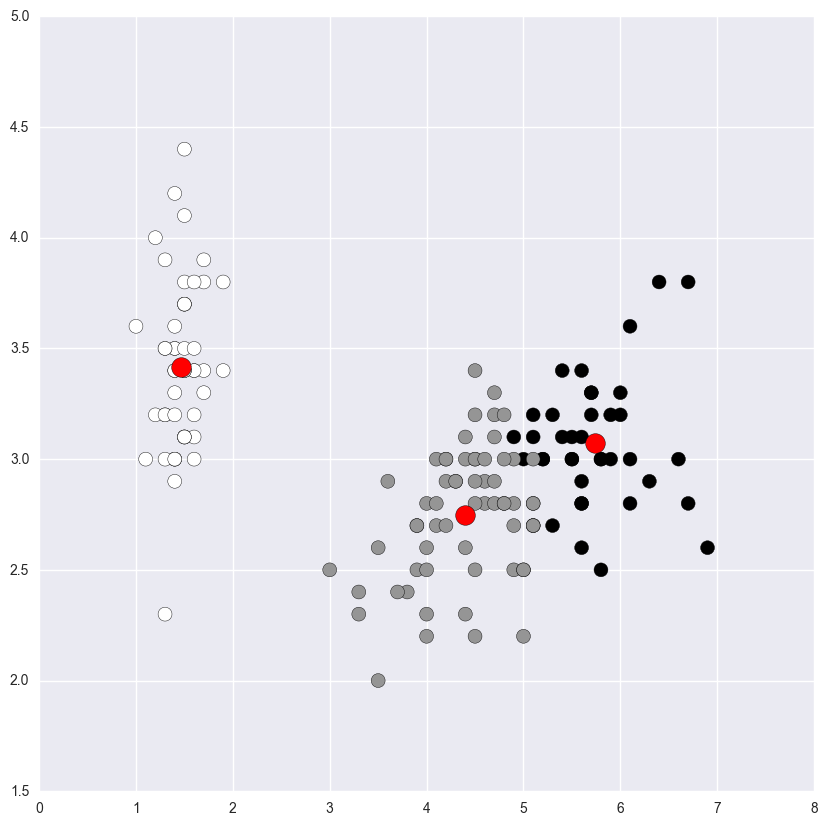

In [2]:
iris = datasets.load_iris()

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
%time {km.fit(iris['data'])}

labels = km.predict(iris['data'])
print(adjusted_mutual_info_score(iris['target'], labels))

plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,2], km.cluster_centers_[:,1], c='r', s=200)
plt.show()

Results are worse than hierarchical clustering

## GMM

Now for Gaussian Mixture Models, first using spherical clusters as estimation method.

CPU times: user 31 µs, sys: 2 µs, total: 33 µs
Wall time: 38.4 µs
0.733117988905
855.341083135


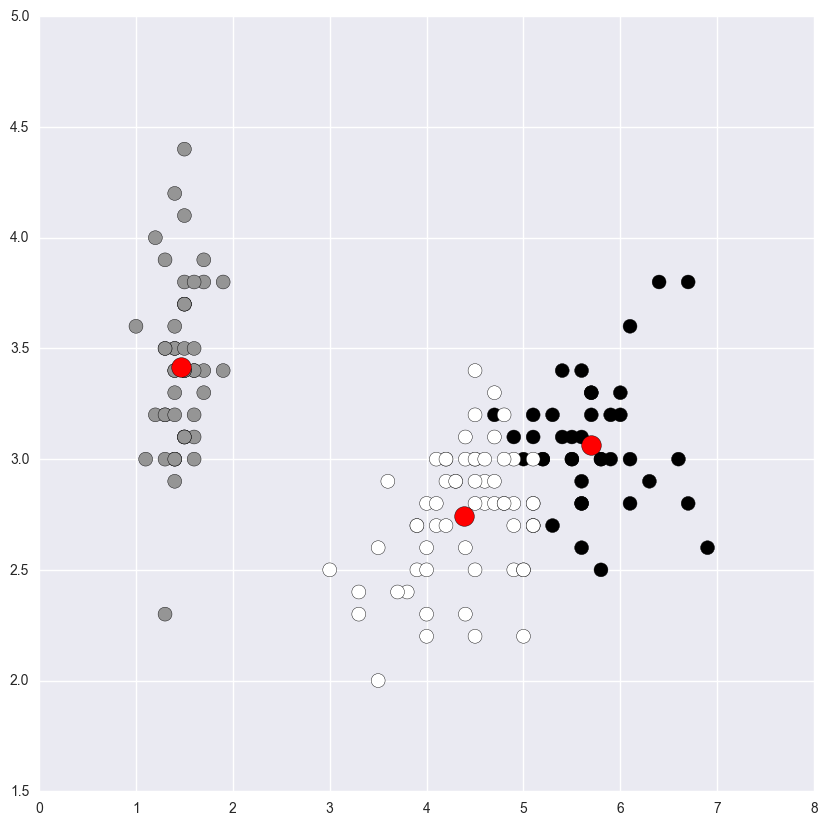

In [3]:
from sklearn.mixture import GMM
gmm = GMM(n_components=3, covariance_type='spherical')
%time {gmm.fit(iris['data'])}

labels = gmm.predict(iris['data'])
print(adjusted_mutual_info_score(iris['target'], labels))
print(gmm.bic(iris['data']))

plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200)
plt.show()

As expected the results is comparable to the one from K-means.

Let's change the method of estimation assuming independent attributes (diagonal covariance).


CPU times: user 39 µs, sys: 3 µs, total: 42 µs
Wall time: 45.5 µs
0.775960558552
747.795555546


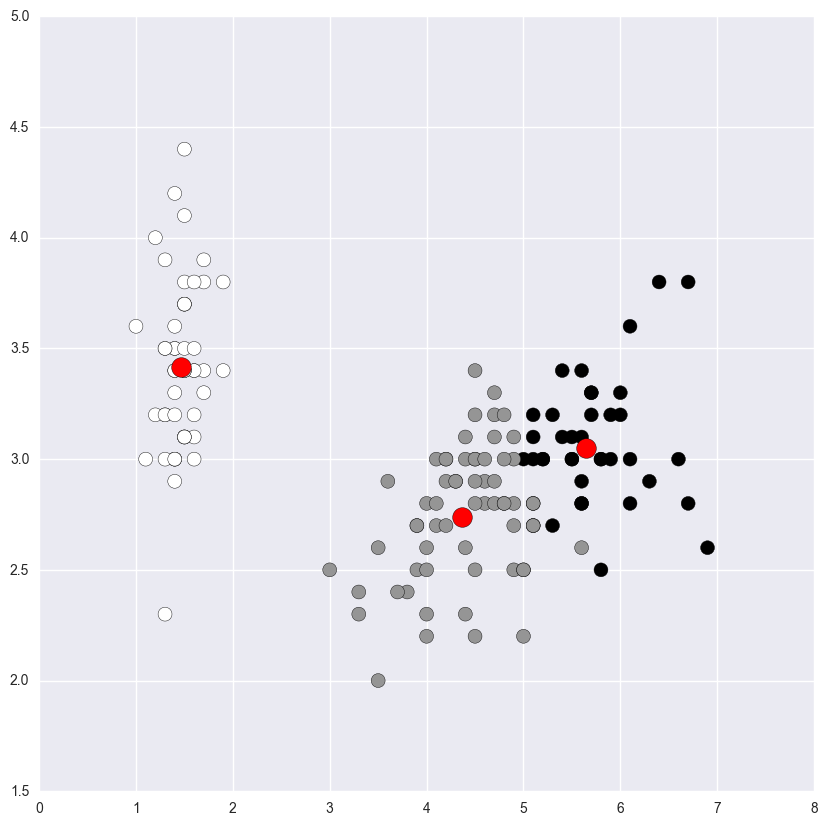

In [4]:
gmm = GMM(n_components=3, covariance_type='diag')
%time {gmm.fit(iris['data'])}

labels = gmm.predict(iris['data'])
print(adjusted_mutual_info_score(iris['target'], labels))
print(gmm.bic(iris['data']))

plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200)
plt.show()

Now we change to the full model, with dependent attributes

CPU times: user 36 µs, sys: 1 µs, total: 37 µs
Wall time: 42 µs
0.897053715016
583.390913061


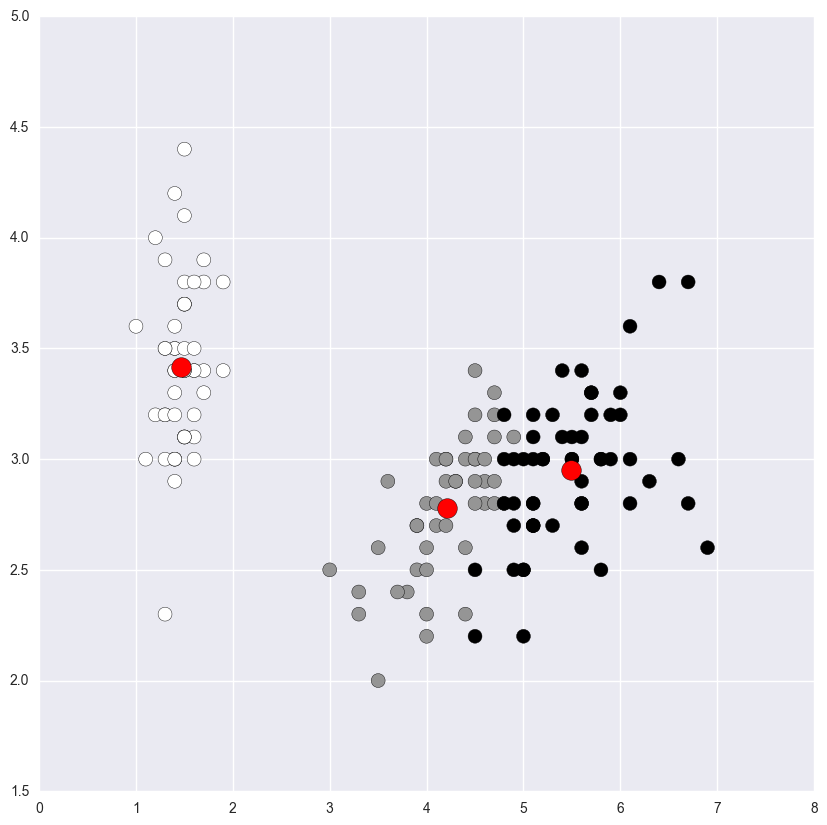

In [5]:
gmm = GMM(n_components=3, covariance_type='full')
%time {gmm.fit(iris['data'])}

labels = gmm.predict(iris['data'])
print(adjusted_mutual_info_score(iris['target'], labels))
print(gmm.bic(iris['data']))

plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200)
plt.show()

This is now the **best model** we have found

## Leader Algorithm

Now we use the Leader Algorithm (from amltlearn), the main problem is to guess a radius that results in the number of clusters we want and the quality could not be the best, the upside is that this algorithm is faster than the rest.

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.7 µs
0.784252780334


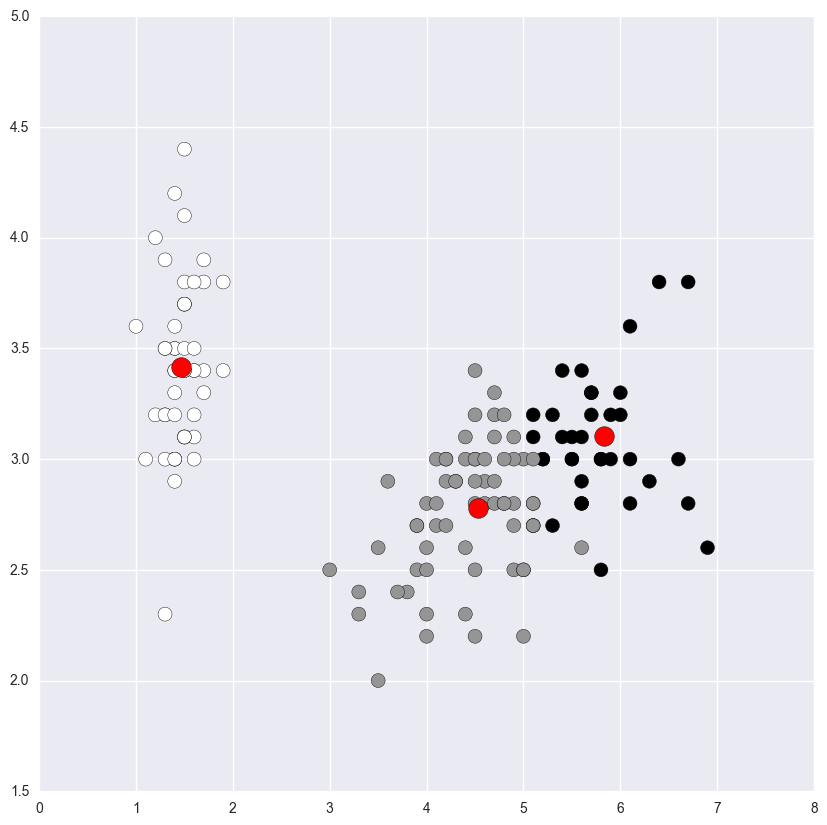

In [6]:
from amltlearn.cluster import Leader

lead = Leader(radius=2.5)
%time {lead.fit(iris['data'])}
labels = lead.predict(iris['data'])
print(adjusted_mutual_info_score(iris['target'], labels))

plt.figure(figsize=(10,10))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(lead.cluster_centers_[:,2], lead.cluster_centers_[:,1], c='r', s=200)
plt.show()

#Issues with K-means

Now we will generate artificial data to see some issues of K-means. The first problem appears when the clusters have different sizes and variances. Depending on the ratio of sizes and variance difference, part of the examples from the larger cluster could be assigned to the small one.

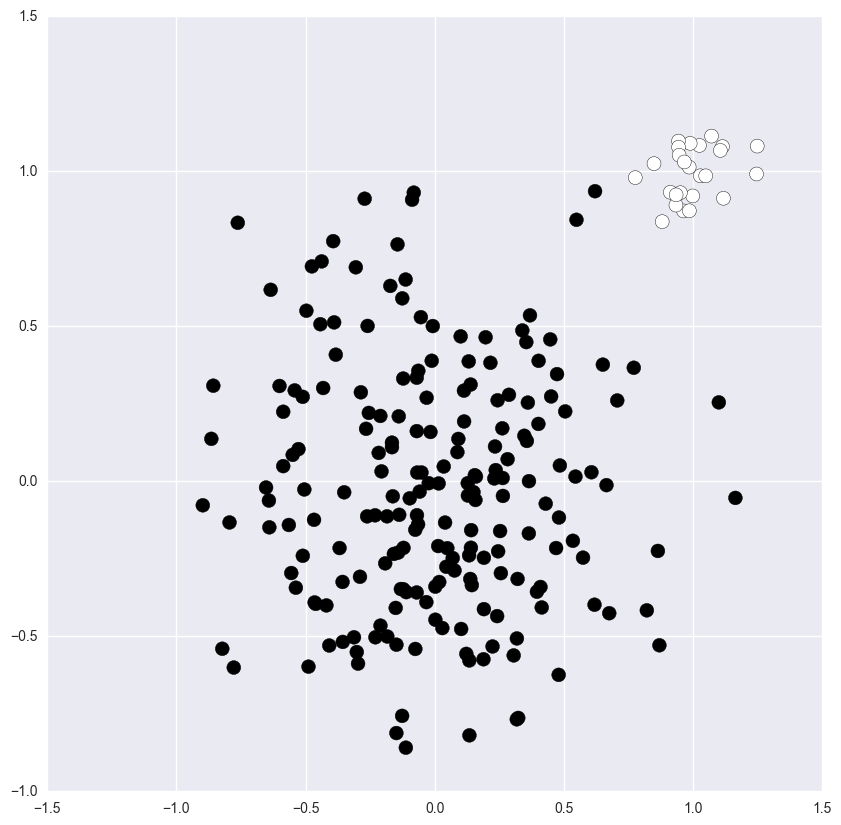

In [7]:
from amltlearn.datasets import make_blobs
blobs, blabels = make_blobs(n_samples=[25,200], n_features=2, centers=[[1,1], [0,0]], cluster_std=[0.1,0.4])

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blabels, s=100)
plt.show()

0.491515339078


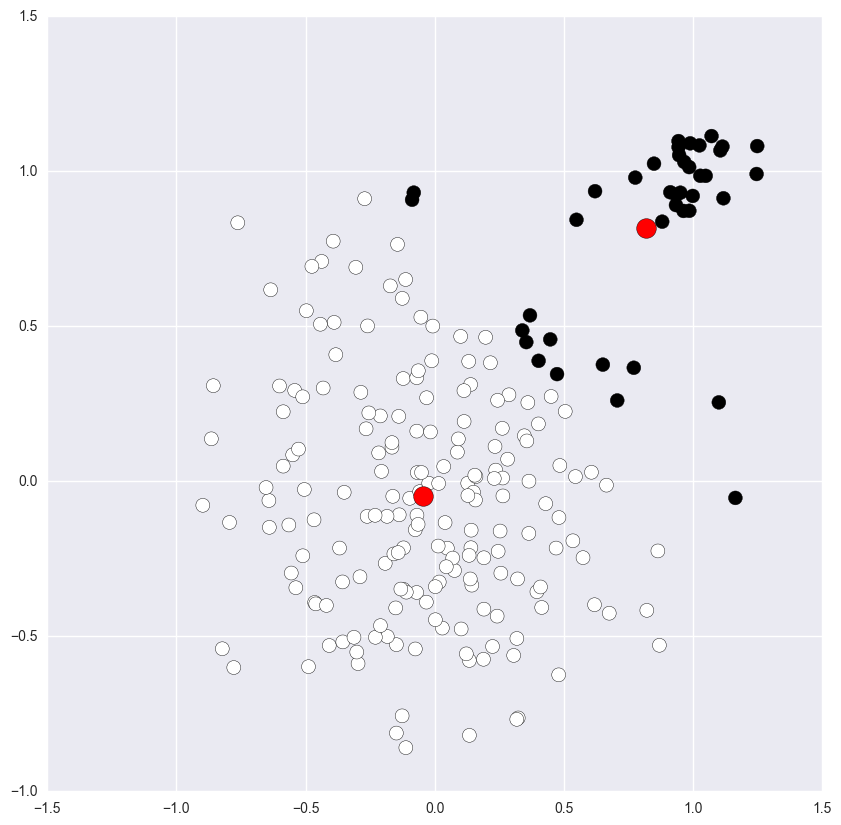

In [8]:
km = KMeans(n_clusters=2)
km.fit(blobs)

labels = km.fit_predict(blobs)

print(adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(10,10))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,0], c='r', s=200)
plt.show()

This could affect less to the GMM algorithm, but it is not free of this problem.

0.921299662079


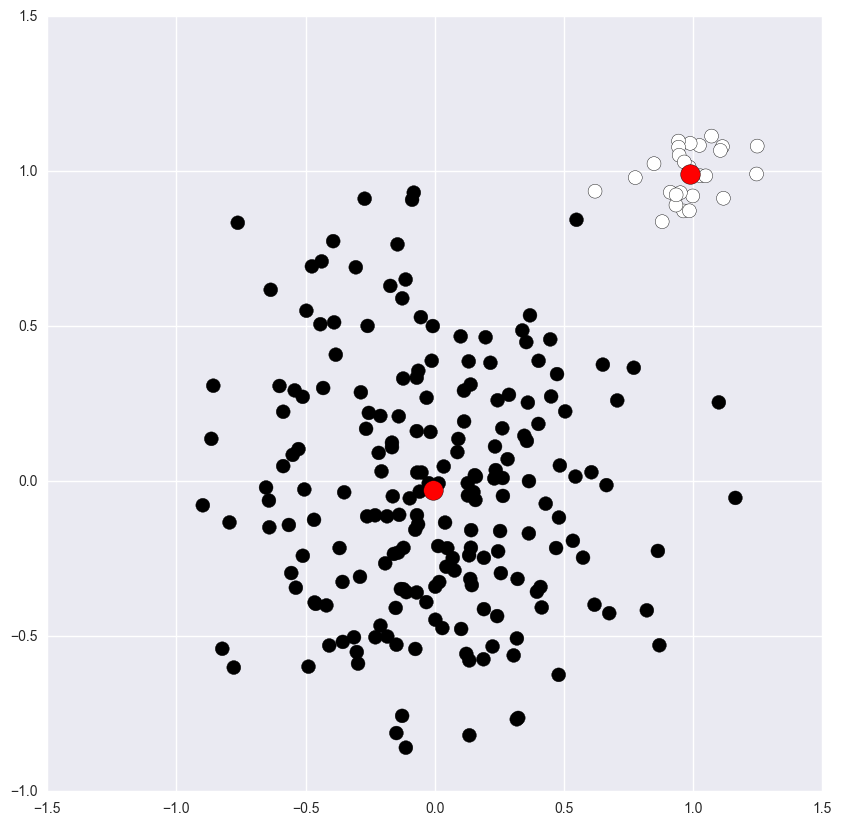

In [9]:
gmm = GMM(n_components=2, covariance_type='diag')
gmm.fit(blobs)

labels = gmm.predict(blobs)
print(adjusted_mutual_info_score(blabels, labels))

plt.figure(figsize=(10,10))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='r', s=200)
plt.show()

You can play with the size, variance and positions of the cluster to see what happens.

Problems also appear when the clusters are not spherical and some attributes have more variance than others (actually are elipsoids). If the clusters are not well separated, the partition can result in not very natural clusters. You can change this data set and see what happens if you change the size, separation and variance of the clusters.

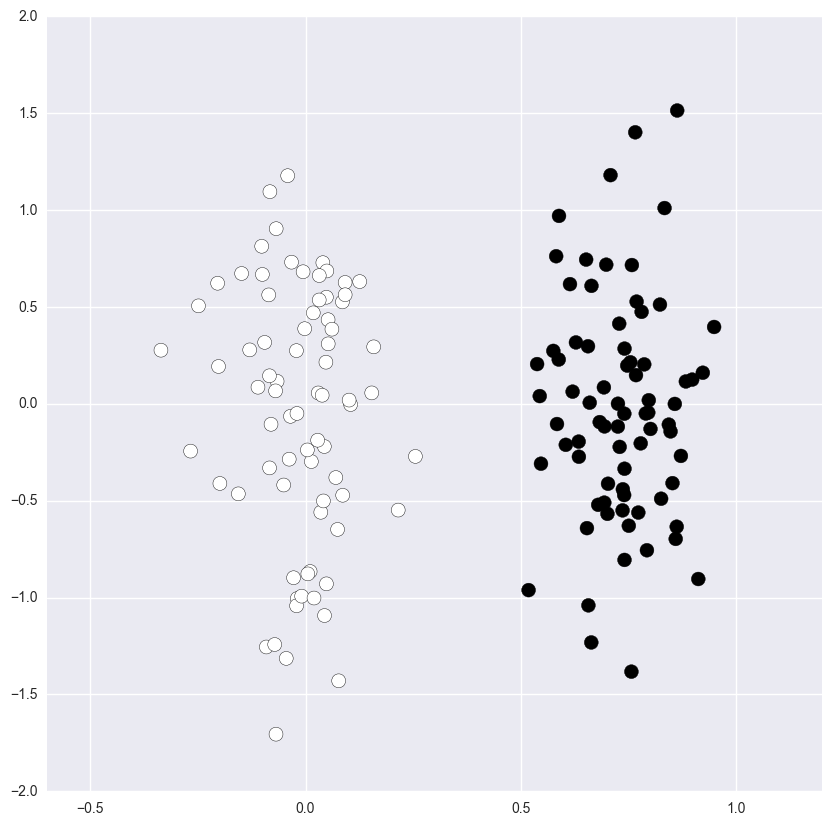

In [11]:
from numpy.random import normal
import numpy as np

size1 = 75
size2 = 75
data = np.zeros((size1+size2,2))

data[0:size1, 0] = normal(loc=0.0, scale=0.1, size=size1)
data[0:size1, 1] = normal(loc=0.0, scale=0.6, size=size1)
data[size1:, 0] = normal(loc=0.75, scale=0.1, size=size2)
data[size1:, 1] = normal(loc=0.0, scale=0.6, size=size2)

dlabels = np.zeros(size1+size2)
dlabels[size1:] = 1

plt.figure(figsize=(10,10))
plt.scatter(data[:, 0], data[:, 1], c=dlabels, s=100)
plt.show()

K-means divides the two clusters wrong (sometimes depends on the initialization, you can use the random_state parameter of K-means to see if different initializations get it right)

-0.00162099139723


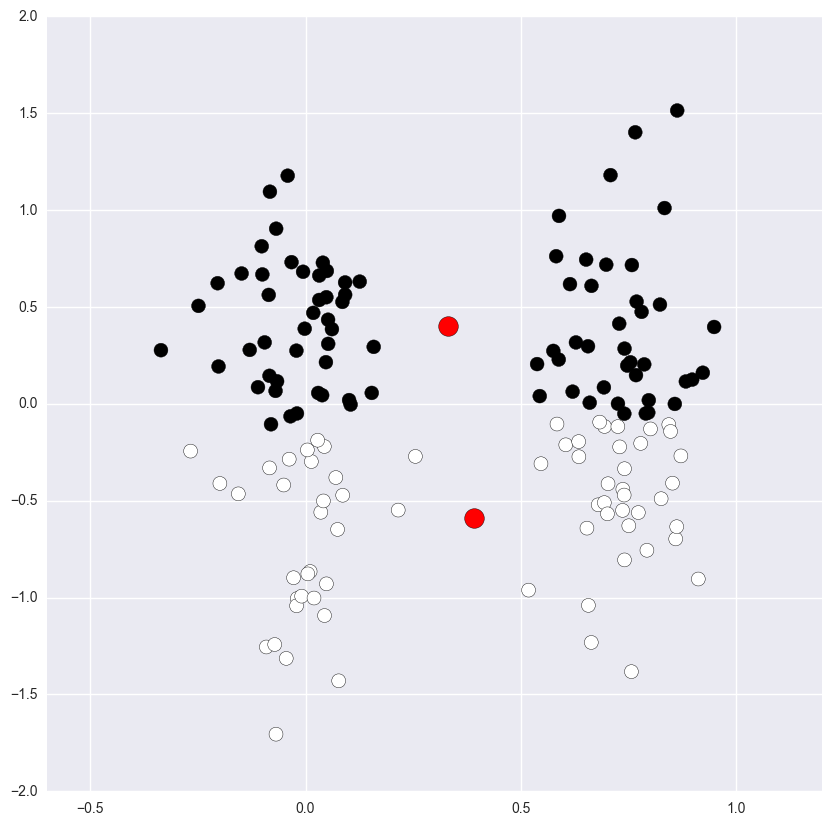

In [12]:
km = KMeans(n_clusters=2)
km.fit(data)

labels = km.fit_predict(data)

print(adjusted_mutual_info_score(dlabels, labels))

plt.figure(figsize=(10,10))
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='r', s=200)
plt.show()

The same happens to GMM (also depends in initalization)

0.00341856376342


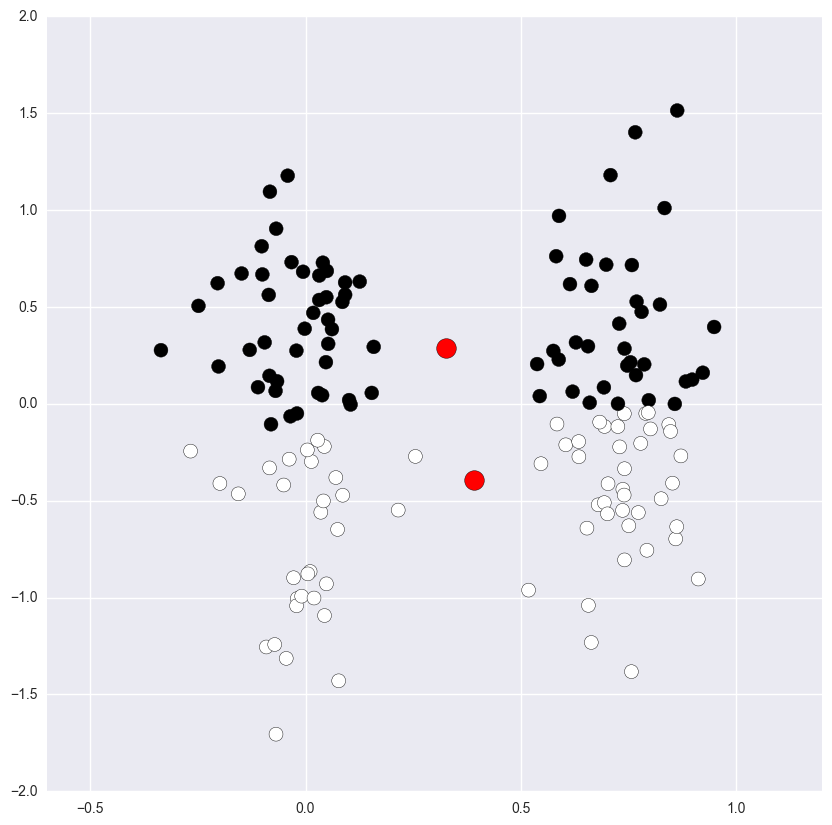

In [13]:
gmm = GMM(n_components=2, covariance_type='diag')
gmm.fit(data)

labels = gmm.predict(data)
print(adjusted_mutual_info_score(dlabels, labels))

plt.figure(figsize=(10,10))
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='r', s=200)
plt.show()

If you play with the characteristics of the dataset, you will see that usually if data are separated enough or the variances are different enough, clusters that have similar number of examples are partitioned right most of the time.